# Load Libraries and Data

In [101]:
from platform import python_version

print(python_version())

3.8.3


In [102]:
import pandas as pd
import seaborn as sns
import re
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [103]:
housing_data_csv = 'D:/OneDrive - PACCAR Inc/Current_Projects/Personal/Courses/DataScientist/Project 1/cov2_crimerate/src/data/Bellingham_Property_Sale_Combined.csv'
data = pd.read_csv(housing_data_csv, index_col=[0]).reset_index()

In [104]:
print("data:", data.shape)

data: (18914, 11)


In [105]:
data.columns

Index(['Unique ID', 'Address', 'Sale Date_part1', 'Sale Price',
       'assesors_link_part1', 'Neighborhood_org', 'Land Acres_org',
       'Built Sq ft_org', 'bedroom_org', 'bathroom_org', 'year_built_org'],
      dtype='object')

# Exploratory Data Analysis

In [106]:
data.describe()

,Land Acres_org,bedroom_org,bathroom_org
count,18914.000000,18914.000000,18914.000000
mean,1.262465,2.406366,1.881939
std,14.158807,1.319412,1.177508
min,0.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000
50%,0.130000,3.000000,2.000000
75%,0.290000,3.000000,3.000000
max,660.000000,11.000000,14.000000


In [107]:
data.isnull().sum()

Unique ID              0
Address                0
Sale Date_part1        0
Sale Price             0
assesors_link_part1    0
Neighborhood_org       0
Land Acres_org         0
Built Sq ft_org        0
bedroom_org            0
bathroom_org           0
year_built_org         0
dtype: int64

In [108]:
print(data.dtypes)

Unique ID               object
Address                 object
Sale Date_part1         object
Sale Price              object
assesors_link_part1     object
Neighborhood_org        object
Land Acres_org         float64
Built Sq ft_org         object
bedroom_org              int64
bathroom_org             int64
year_built_org          object
dtype: object


In [109]:
data.head()

,Unique ID,Address,Sale Date_part1,Sale Price,assesors_link_part1,Neighborhood_org,Land Acres_org,Built Sq ft_org,bedroom_org,bathroom_org,year_built_org
0,12/20/2016_sep_Property.aspx?cid=0&year=2021&p...,"FAZON RD \nBELLINGHAM, WA",12/20/2016,"$30,300.00",Property.aspx?cid=0&year=2021&prop_id=106797,3270010100,2.53,0,0,0,0
1,02/25/2016_sep_Property.aspx?cid=0&year=2021&p...,"BELLINGHAM, WA",2/25/2016,"$25,000.00",Property.aspx?cid=0&year=2021&prop_id=27798,4310010100,0.00,0,0,0,0
2,02/25/2016_sep_Property.aspx?cid=0&year=2021&p...,"BELLINGHAM, WA",2/25/2016,"$25,000.00",Property.aspx?cid=0&year=2021&prop_id=27800,4310010100,0.00,0,0,0,0
3,02/25/2016_sep_Property.aspx?cid=0&year=2021&p...,"BELLINGHAM, WA",2/25/2016,"$25,000.00",Property.aspx?cid=0&year=2021&prop_id=27803,4310010100,0.00,0,0,0,0
4,02/25/2016_sep_Property.aspx?cid=0&year=2021&p...,"BELLINGHAM, WA",2/25/2016,"$25,000.00",Property.aspx?cid=0&year=2021&prop_id=27812,4310010100,0.00,0,0,0,0


# Clean Data

In [112]:
def clean_Housing_df(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    df - clean pandas dataframe
    
    Perform to obtain the correct cleaned df object
    This function cleans df using the following steps to produce clean df:
    1. Create a column to define property type
    2. Drop channels for required
    3. clean and change df type address, sale price, built sq ft, and year built column 
    4. create column for street block, street name, address block
    5. create a dummy variable for all categories in neighborhood classification
    6.add month to df
    '''
    
    #create a column to define property type
    df['type'] ='Residential'
    df.loc[(df['year_built_org']=='0'),'type'] = 'Land'
    
    #drop channels not needed
    df =df.drop(columns = ['Unique ID','assesors_link_part1'])
    
    #clean and change df type address, sale price, built sq ft, and year built column 
    df.Address = df.Address.str.split('\n').str[0]
    df.Address=df.Address.apply(lambda x: ' '.join(x.split()))
    df['Sale Price'] = df['Sale Price'].replace('[\$,]', '', regex=True).astype(float)
    df['Built Sq ft_org'] = df['Built Sq ft_org'].replace('sqft', '', regex=True).astype(float)
    df['year_built_org'] = pd.to_numeric(df['year_built_org'],errors = 'coerce').fillna(0).astype(int)  
    
    #create column for street block
    df['StreetBLK'] = (df.Address.apply(lambda x: re.findall(r'(\d+) ', x)[0] if 
                                            len(re.findall(r'(\d+) ', x))>0 else 0).astype(int)/100).astype(int)*100
    #create column for street number
    df['Streetnumber'] = df.Address.apply(lambda x: re.findall(r'(\d+) ', x)[0] if 
                                            len(re.findall(r'(\d+) ', x))>0 else 0).astype(int)
   
    #create column for street name
    df['StreetName'] = df.Address.apply(lambda x: ' '.join(x.split()[1:]) if 
                                            len(re.findall(r'(\d+) ', x))>0 else x).str.split('#').str[0]
    #create column for address block
    df['Address Block']= df['StreetBLK'].astype(str) +' '+df['StreetName']
    
    #create short address
    df['ShortAddress'] = df['Streetnumber'].astype(str) +' '+df['StreetName']
    
    #create a dummy variable for all categories in neighborhood classification
    flat_list = df.Neighborhood_org.values.tolist()
    flat_list = [re.split(' |-',item) for item in flat_list]
    flat_list=[item for sublist in flat_list for item in sublist]
    flat_list = list(filter(None, flat_list))
    flat_list = list(set(flat_list))
    #Create a column for each category in neighborhood classification
    for col in flat_list:
        df[col] = df.Neighborhood_org.apply(lambda x: 1 if len(re.findall(re.escape(col), x))>0 else 0)
    
    #add month to df
    df['Month'] = pd.to_datetime(df['Sale Date_part1']).dt.to_period("M")
    
    #columns type
    all_cols = df.columns
    object_cols = df.select_dtypes(include=['object']).columns
    numeric_cols = list(set(all_cols) - set(object_cols))
    
    #loop through each sale and if multiple sales from same day exist average them
    for index, row in tqdm(df.iterrows()): #function will show a progress indicator
        all_housing_data = df[df.ShortAddress.str.contains(row['ShortAddress'])]
        if len(all_housing_data)>2: #only operate where more one data point is available for a house
            df.loc[df.ShortAddress.str.contains(row['ShortAddress']),numeric_cols] = df.loc[df.ShortAddress.
                                                                                                  str.contains(row['ShortAddress']),:].groupby('Sale Date_part1').transform('mean') 

    #add month to df
    df['Month'] = pd.to_datetime(df['Sale Date_part1']).dt.to_period("M")
    
    return df

    
#Use the function to clean input data
data = clean_Housing_df(data)  

data.head()

18914it [1:48:30,  2.91it/s]


,Address,Sale Date_part1,Sale Price,Neighborhood_org,Land Acres_org,Built Sq ft_org,bedroom_org,bathroom_org,year_built_org,type,...,6420012000,6470012000,5310612000,MH,6450010600,6410651000,3250010803,2120020500,RAC,Month
0,FAZON RD,12/20/2016,30300.0,3270010100,2.53,0.0,0.0,0.0,0.0,Land,...,0.0,0,0.0,0.0,0,0,0,0,0.0,2016-12
1,"BELLINGHAM, WA",2/25/2016,25000.0,4310010100,0.00,0.0,0.0,0.0,0.0,Land,...,0.0,0,0.0,0.0,0,0,0,0,0.0,2016-02
2,"BELLINGHAM, WA",2/25/2016,25000.0,4310010100,0.00,0.0,0.0,0.0,0.0,Land,...,0.0,0,0.0,0.0,0,0,0,0,0.0,2016-02
3,"BELLINGHAM, WA",2/25/2016,25000.0,4310010100,0.00,0.0,0.0,0.0,0.0,Land,...,0.0,0,0.0,0.0,0,0,0,0,0.0,2016-02
4,"BELLINGHAM, WA",2/25/2016,25000.0,4310010100,0.00,0.0,0.0,0.0,0.0,Land,...,0.0,0,0.0,0.0,0,0,0,0,0.0,2016-02


In [114]:
data.describe(include = 'all')

,Address,Sale Date_part1,Sale Price,Neighborhood_org,Land Acres_org,Built Sq ft_org,bedroom_org,bathroom_org,year_built_org,type,...,6420012000,6470012000,5310612000,MH,6450010600,6410651000,3250010803,2120020500,RAC,Month
count,18914,18914,1.891400e+04,18914,18914.000000,1.891400e+04,18914.000000,18914.000000,18914.000000,18914,...,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914
unique,13840,1776,NaN,228,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73
top,"BELLINGHAM, WA",6/27/2016,NaN,6410012000 SFR-LOT,NaN,NaN,NaN,NaN,NaN,Residential,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06
freq,268,66,NaN,2853,NaN,NaN,NaN,NaN,NaN,16638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410
mean,NaN,NaN,4.721437e+05,NaN,1.262465,9.346764e+03,2.406366,1.881939,1733.371207,NaN,...,0.005816,0.000899,0.002961,0.015491,0.000159,0.000053,0.000106,0.000159,0.019615,NaN
std,NaN,NaN,1.454870e+06,NaN,9.504239,1.091257e+06,1.313177,1.172384,650.279574,NaN,...,0.075867,0.029967,0.053845,0.123392,0.012593,0.007271,0.010283,0.012593,0.132535,NaN
min,NaN,NaN,1.000000e+00,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,2.265572e+05,NaN,0.000000,9.599118e+02,2.000000,1.000000,1931.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,3.350000e+05,NaN,0.130000,1.392000e+03,3.000000,2.000000,1983.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,NaN,NaN,4.699000e+05,NaN,0.290000,1.854000e+03,3.000000,3.000000,2004.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


## Merge with Crime Data

In [119]:
crime_data_csv = 'D:/OneDrive - PACCAR Inc/Current_Projects/Personal/Courses/DataScientist/Project 1/cov2_crimerate/data/2_interim/COB_CrimeReport.csv'
crime_data = pd.read_csv(crime_data_csv, index_col=[0])

In [120]:
def clean_Crime_df(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    df - clean pandas dataframe
    
    Perform to obtain the correct cleaned df object
    This function cleans df using the following steps to produce clean df:
    1.add month to df
    2. clean location and create column for street block and street name
    '''
    
    #add month to df
    df['Month'] = pd.to_datetime(df['Date']).dt.to_period("M")
    
    #clean location and create column for street block and street name
    df.Location=df.Location.str.replace('BLK ', '', regex=True).apply(lambda x: ' '.join(x.split()))
    df['StreetBLK'] = df.Location.str.split().str[0].astype(int)
    df['StreetName'] = df.Location.apply(lambda x:' '.join(x.split()[1:]))
    
    return df

    
#Use the function to clean input data
crime_data = clean_Crime_df(crime_data)  

crime_data.head()

,Date,Location,Offence,Crime Category,Case,Month,StreetBLK,StreetName
11400,Jun 2 2015 2:21PM,1400 WOBURN ST,911 HANG UP CALL,Other,15B24377Officers attempted to locate the sour...,2015-06,1400,WOBURN ST
29704,Apr 5 2016 9:30AM,1300 TEXAS ST,911 HANG UP CALL,Other,16B11316Citizen reported a 7 yr old child cal...,2016-04,1300,TEXAS ST
41070,Oct 6 2016 2:56PM,200 SAMISH WAY,911 HANG UP CALL,Other,16B44312Officers responded to a 911 Hang Up c...,2016-10,200,SAMISH WAY
58653,Aug 16 2017 12:00PM,400 BARNES RD,911 HANG UP CALL,Other,17B32138911 hang up from that address.,2017-08,400,BARNES RD
69480,Feb 26 2018 8:00AM,4300 GOODING AVE,911 HANG UP CALL,Other,17B64037Officers responded to a residence for...,2018-02,4300,GOODING AVE


In [122]:
def merge_housingAndCrime_df(housing_df,crime_df,months_to_integrate):
    '''
    INPUT
    housing_df - pandas dataframe with cleaned housing info 
    crime_df - pandas dataframe with clean crime info
    months_to_integrate - number of months of crime data to integrate
    
    OUTPUT
    df - merged housing and crime data
    
    This function cleans merges housing and crime dataset. For each sale, the function
    looks up the block location and integrates the crime in various categories in a given window 
    prior to the sale (defined by months_to_integrate)
    
    Perform to obtain the correct merged df object
    1. Create a new colum for each crime category with prefix based on the number of months to integrate
    
    '''
    
    #create a column with zeros for each category in crime type
    for col in [str(months_to_integrate)+'M_' + s for s in crime_df['Crime Category'].value_counts().index.tolist()]:
        housing_df[col] = 0
    
    #create a column for total crime
    housing_df[str(months_to_integrate)+'M_TotalCrime'] = 0

    #loop through each sale and integrate the crime
    for index, row in tqdm(housing_df.iterrows()): #function will show a progress indicator
        all_crime_df = crime_df[crime_df.Location==row['Address Block']]
        if len(all_crime_df)>0: #only operate where there is crime housing_df available
            #filter timewindow for crime integration
            begin = row['Month']-months_to_integrate # month start integration
            end = row['Month'] #sale month
            crime_df_windowed = all_crime_df[((all_crime_df['Month']>begin) & (all_crime_df['Month']<end))]
            #aggregate crime            
            crime_df_agg=crime_df_windowed.groupby(['Crime Category'])['Case'].count().reset_index()
            crime_df_agg['Crime Category'] = str(months_to_integrate)+'M_' + crime_df_agg['Crime Category'].astype(str)
            #populate integrated crime columns
            housing_df.loc[index,str(months_to_integrate)+'M_TotalCrime']=crime_df_agg.Case.values.sum()
            dictionary = dict(zip(crime_df_agg['Crime Category'].values.tolist(), crime_df_agg['Case'].values.tolist()))
            for k,v in dictionary.items():
                housing_df.loc[index,k] = v    
    return housing_df

#Use the function to merge data
months_to_integrate = 6
data = merge_housingAndCrime_df(data,crime_data,months_to_integrate) 

data.head()

18914it [02:50, 111.19it/s]


,Address,Sale Date_part1,Sale Price,Neighborhood_org,Land Acres_org,Built Sq ft_org,bedroom_org,bathroom_org,year_built_org,type,...,6M_Other,6M_ DRUG - NARCOTICS VIOLATIONS,6M_Death Investigation,6M_Juvenile,6M_ DEATH INVESTIGATION,6M_ ANIMAL PROBLEM,6M_DRUG - NARCOTICS VIOLATIONS,6M_ ANIMAL ABUSE,6M_Industrial Accident,6M_TotalCrime
0,FAZON RD,12/20/2016,30300.0,3270010100,2.53,0.0,0.0,0.0,0.0,Land,...,0,0,0,0,0,0,0,0,0,0
1,"BELLINGHAM, WA",2/25/2016,25000.0,4310010100,0.00,0.0,0.0,0.0,0.0,Land,...,0,0,0,0,0,0,0,0,0,0
2,"BELLINGHAM, WA",2/25/2016,25000.0,4310010100,0.00,0.0,0.0,0.0,0.0,Land,...,0,0,0,0,0,0,0,0,0,0
3,"BELLINGHAM, WA",2/25/2016,25000.0,4310010100,0.00,0.0,0.0,0.0,0.0,Land,...,0,0,0,0,0,0,0,0,0,0
4,"BELLINGHAM, WA",2/25/2016,25000.0,4310010100,0.00,0.0,0.0,0.0,0.0,Land,...,0,0,0,0,0,0,0,0,0,0


In [123]:
data.describe(include='all')

,Address,Sale Date_part1,Sale Price,Neighborhood_org,Land Acres_org,Built Sq ft_org,bedroom_org,bathroom_org,year_built_org,type,...,6M_Other,6M_ DRUG - NARCOTICS VIOLATIONS,6M_Death Investigation,6M_Juvenile,6M_ DEATH INVESTIGATION,6M_ ANIMAL PROBLEM,6M_DRUG - NARCOTICS VIOLATIONS,6M_ ANIMAL ABUSE,6M_Industrial Accident,6M_TotalCrime
count,18914,18914,1.891400e+04,18914,18914.000000,1.891400e+04,18914.000000,18914.000000,18914.000000,18914,...,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.0,18914.000000
unique,13840,1776,NaN,228,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,"BELLINGHAM, WA",6/27/2016,NaN,6410012000 SFR-LOT,NaN,NaN,NaN,NaN,NaN,Residential,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,268,66,NaN,2853,NaN,NaN,NaN,NaN,NaN,16638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,4.721437e+05,NaN,1.262465,9.346764e+03,2.406366,1.881939,1733.371207,NaN,...,0.047690,0.008301,0.006292,0.009411,0.006345,0.001480,0.000793,0.000053,0.0,0.657397
std,NaN,NaN,1.454870e+06,NaN,9.504239,1.091257e+06,1.313177,1.172384,650.279574,NaN,...,0.316201,0.118526,0.086726,0.139552,0.082022,0.041107,0.028151,0.007271,0.0,2.835503
min,NaN,NaN,1.000000e+00,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,NaN,NaN,2.265572e+05,NaN,0.000000,9.599118e+02,2.000000,1.000000,1931.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,NaN,NaN,3.350000e+05,NaN,0.130000,1.392000e+03,3.000000,2.000000,1983.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,NaN,NaN,4.699000e+05,NaN,0.290000,1.854000e+03,3.000000,3.000000,2004.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [124]:
data.to_csv('Cleaned_Merged_Housing_Crime_Data.csv')

In [127]:
data.select_dtypes(include=['object'])

,Address,Sale Date_part1,Neighborhood_org,type,StreetName,Address Block,ShortAddress
0,FAZON RD,12/20/2016,3270010100,Land,FAZON RD,0 FAZON RD,0 FAZON RD
1,"BELLINGHAM, WA",2/25/2016,4310010100,Land,"BELLINGHAM, WA","0 BELLINGHAM, WA","0 BELLINGHAM, WA"
2,"BELLINGHAM, WA",2/25/2016,4310010100,Land,"BELLINGHAM, WA","0 BELLINGHAM, WA","0 BELLINGHAM, WA"
3,"BELLINGHAM, WA",2/25/2016,4310010100,Land,"BELLINGHAM, WA","0 BELLINGHAM, WA","0 BELLINGHAM, WA"
4,"BELLINGHAM, WA",2/25/2016,4310010100,Land,"BELLINGHAM, WA","0 BELLINGHAM, WA","0 BELLINGHAM, WA"
...,...,...,...,...,...,...,...
18909,2609 LUMMI SHORE RD,1/21/2016,ZERO VALUE PROP,Land,LUMMI SHORE RD,2600 LUMMI SHORE RD,2609 LUMMI SHORE RD
18910,STUART RD,3/27/2019,ZERO VALUE PROP,Land,STUART RD,0 STUART RD,0 STUART RD
18911,86 LOUISE VIEW DR,4/6/2017,ZERO VALUE PROP,Land,LOUISE VIEW DR,0 LOUISE VIEW DR,86 LOUISE VIEW DR
18912,77 LOUISE VIEW DR,4/25/2016,ZERO VALUE PROP,Land,LOUISE VIEW DR,0 LOUISE VIEW DR,77 LOUISE VIEW DR


## Machine Learning Model

In [128]:
def create_ML_df(df, drop_cols):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows which are of type land
    2. Create X as all the columns that are not the Sale Price column
    3. Create y as the Sale Price column
    4. Drop the Address, Street Blk, Street Name, Address Block, Sale Data columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    df = df[df['type']!='Land']
    
    #Drop all the rows with no salaries
    df=df.dropna(subset=['Sale Price'])
    
    #Create X as all the columns that are not the Salary column
    X = df.drop(columns = 'Sale Price',axis =1)
    
    #Drop the not required columnb from X
    X = X.drop(columns = drop_cols,axis =1)
       
    #Create y as the Salary column
    y = df['Sale Price']
        
    #Create dummy columns for all the categorical variables in X, drop the original columns
    X.Month = X.Month.astype(str)
    cat_X = X.select_dtypes(include=['object'])
    cat_cols = cat_X.columns
    cat_X = pd.get_dummies(cat_X,dummy_na=False,prefix=cat_cols,drop_first=True)

    #For each numeric variable in X, fill the column with the mean value of the column.
    num_X = X.drop(cat_cols, axis=1)

    X = pd.concat([num_X, cat_X], axis=1)
    
    #Drop columns that are fixed
    X = X.loc[:, (X != X.iloc[0]).any()] 

    return X, y
    

#Use the function to create X and y
drop_cols = ['Address','type','StreetBLK','StreetName','Address Block','Sale Date_part1','Neighborhood_org','ShortAddress']
X, y = create_ML_df(data,drop_cols)    
X.head()

,Land Acres_org,Built Sq ft_org,bedroom_org,bathroom_org,year_built_org,Streetnumber,5410611000,6470010300,MIN,2150010200,...,Month_2020-05,Month_2020-06,Month_2020-07,Month_2020-08,Month_2020-09,Month_2020-10,Month_2020-11,Month_2020-12,Month_2021-01,Month_2021-02
20,2.16,1080.0,2.0,2.0,1959.0,1210.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
26,1.06,1398.0,3.0,2.0,1973.0,1203.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
27,0.36,1196.0,2.0,1.0,1905.0,5323.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
28,1.86,966.0,3.0,1.0,1951.0,5141.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
30,0.69,1680.0,3.0,4.0,1969.0,5854.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
X.describe()

,Land Acres_org,Built Sq ft_org,bedroom_org,bathroom_org,year_built_org,Streetnumber,5410611000,6470010300,MIN,2150010200,...,Month_2020-05,Month_2020-06,Month_2020-07,Month_2020-08,Month_2020-09,Month_2020-10,Month_2020-11,Month_2020-12,Month_2021-01,Month_2021-02
count,16638.000000,1.663800e+04,16638.000000,16638.000000,16638.000000,16638.000000,16638.000000,16638.00000,16638.000000,16638.000000,...,16638.000000,16638.000000,16638.000000,16638.000000,16638.000000,16638.000000,16638.000000,16638.000000,16638.000000,16638.000000
mean,0.569083,1.062241e+04,2.731335,2.135607,1967.306570,2046.017961,0.000060,0.00023,0.000090,0.000120,...,0.008114,0.013403,0.012922,0.015927,0.012081,0.012502,0.010458,0.008775,0.003005,0.000120
std,1.897953,1.163504e+06,1.037653,1.011397,151.721474,1550.908944,0.007753,0.01490,0.006714,0.010964,...,0.089714,0.114997,0.112943,0.125198,0.109250,0.111112,0.101731,0.093266,0.054739,0.010964
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.123000e+03,2.000000,1.823529,1966.000000,700.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.120000,1.486000e+03,3.000000,2.000000,1991.000000,1807.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.250000,1.931750e+03,3.000000,3.000000,2005.000000,3140.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41.200000,1.500800e+08,11.000000,14.000000,2020.000000,7421.000000,1.000000,1.00000,0.500000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [134]:
X.to_csv('MachineLearing_X_beforeFE.csv')
y.to_csv('MachineLearing_y_beforeFE.csv')

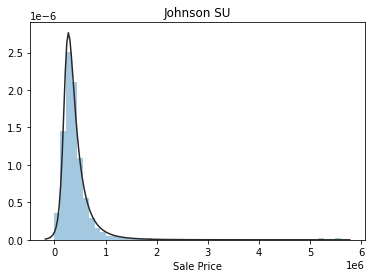

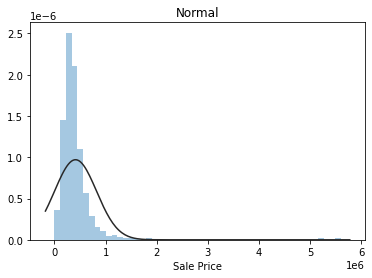

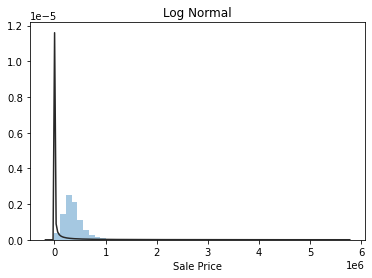

In [130]:
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [131]:
def feature_engineering(X,y):
    '''
    INPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response after feature enginering
    y - the corresponding response vector feature enginering
    
    Perform to obtain the correct X and y objects
    This function process X and y using the following steps to produce X and y:
    1. Perform lop1p transform on y
    2. Perform Box-cox transformation on all numerica X with high skewness
    '''
    
    #Perform lop1p transform on y
    y= np.log1p(y)

    #Perform Box-cox transformation on all numerica X with high skewness
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics2 = []
    for i in X.columns:
        if X[i].dtype in numeric_dtypes:
            numerics2.append(i)
    skew_features = X[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index

    for i in skew_index:
        X[i] = boxcox1p(X[i], boxcox_normmax(X[i] + 1))

    return X, y

#Use the function to engineer
X, y = feature_engineering(X,y)

In [132]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

#Fit your model to the training data
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict the response for the training data and the test data
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)  

#Predict the response for the training data and the test data
train_score = r2_score(y_train, y_train_preds)
test_score=r2_score(y_test, y_test_preds)

print(train_score,test_score)

0.3198305958409374 -2.0097887142520468e+30


In [133]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
66,3270010300,5.555862e+15,5.555862e+15
131,6410612300,6.033016e+14,6.033016e+14
144,6420010200,5.915260e+14,5.915260e+14
85,4310027900,-5.855259e+14,5.855259e+14
167,2120010300,-5.820696e+14,5.820696e+14
158,3270012300,5.605036e+14,5.605036e+14
29,5410052000,5.207892e+14,5.207892e+14
143,5310611000,3.864394e+14,3.864394e+14
127,6410027300,3.816640e+14,3.816640e+14
153,SG,-3.198214e+14,3.198214e+14
